  # 🍄 Enhanced Mushroom Classification Project - Version 2







  ## Project Overview







  Building an improved machine learning model for mushroom classification, incorporating:



  1. Insights from previous model evaluation (Suillus performance, Lactarius-Russula confusion)



  2. Architecture improvements (intermediate layers)



  3. Multiple optimizer comparison







  **Previous Model Results:**



  - Overall Accuracy: 88%



  - Areas for Improvement:



    - Suillus class (F1-score: 0.73)



    - Lactarius-Russula confusion



    - Cortinarius recall (77%)

  ## 1. Imports and Setup



  1. **Basic Dependencies**

    - Core Python libraries (os, time, multiprocessing)

    - NumPy and visualization libraries (matplotlib, seaborn)



 2. **Deep Learning Framework**

    - PyTorch and PyTorch Lightning for model development

    - Torchmetrics for performance metrics

    - Pre-trained ResNet34 model



 3. **Data Augmentation**

    - Albumentations library for image transformations



 4. **System Setup**

    - Windows compatibility with multiprocessing

    - CUDA and Tensor Core configuration

    - Checkpoint directory management

In [ ]:
import os
import time
import multiprocessing
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
from torchvision import models
from torchvision.models import ResNet34_Weights

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, classification_report

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from config import Config
from improved_mushroom_dataset import MushroomDataset
from improved_mushroom_data_module import MushroomDataModule

multiprocessing.set_start_method('spawn', force=True)

if torch.cuda.is_available():
    torch.set_float32_matmul_precision('medium')
    logger.info("Enabled Tensor Cores with medium precision")
    logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")

checkpoint_dir = Path('checkpoints')
if checkpoint_dir.exists():
    import shutil
    shutil.rmtree(checkpoint_dir)
checkpoint_dir.mkdir(exist_ok=True)



c:\Users\kresi\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
INFO:__main__:Enabled Tensor Cores with medium precision
INFO:__main__:Using GPU: NVIDIA GeForce RTX 3070 Laptop GPU


  ## 2. Data Transforms



  This cell defines two transform pipelines:



 1. **Training Transforms**

    - Resizing to consistent dimensions

    - Data augmentation techniques:

      - Flips (horizontal/vertical)

      - Rotations

      - Brightness/contrast adjustments

      - Color jittering

      - Random cropping

    - Normalization using ImageNet statistics



 2. **Validation Transforms**

    - Simple resize operation

    - Normalization only (no augmentation)

In [2]:
train_transforms = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RandomResizedCrop(Config.IMG_SIZE, Config.IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])



  ## 3. Enhanced Model Architecture



   This cell defines the main model architecture:



 1. **Model Components**

    - ResNet34 backbone

    - Custom intermediate layers

    - Special pathways for problem classes

    - Final classifier



 2. **Key Methods**

    - Forward pass implementation

    - Training step with loss calculation

    - Validation step

    - Optimizer configuration



 3. **Special Features**

    - Class weighting for imbalance

    - Multiple optimizer support

    - Custom metrics tracking

In [ ]:
class EnhancedMushroomClassifier(pl.LightningModule):
    def __init__(self, num_classes=Config.NUM_CLASSES, learning_rate=Config.LEARNING_RATE,
                 class_weights=None, optimizer_name='adamw', dropout_rate=0.5):
        super().__init__()
        
        self.save_hyperparameters()
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.class_weights = class_weights
        self.optimizer_name = optimizer_name
        
        self.backbone = models.resnet34(weights=ResNet34_Weights.DEFAULT)
        backbone_output_size = self.backbone.fc.in_features
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        self.intermediate = nn.Sequential(
            nn.Flatten(),
            nn.Linear(backbone_output_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate)
        )
        
        self.special_pathways = nn.ModuleDict({
            'suillus': nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.3)
            ),
            'lactarius_russula': nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.BatchNorm1d(256),
                nn.Dropout(0.3)
            )
        })
        
        self.classifier = nn.Linear(512 + 256 * 2, num_classes)
        
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_classes)
        self.class_f1 = torchmetrics.F1Score(task="multiclass", num_classes=self.num_classes, average=None)

    def forward(self, x):
        features = self.backbone(x)
        intermediate_features = self.intermediate(features)
        
        suillus_features = self.special_pathways['suillus'](intermediate_features)
        lr_features = self.special_pathways['lactarius_russula'](intermediate_features)
        
        combined_features = torch.cat([
            intermediate_features,
            suillus_features,
            lr_features
        ], dim=1)
        
        return self.classifier(combined_features)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y, weight=self.class_weights.to(self.device))
        preds = torch.argmax(logits, dim=1)
        
        acc = self.train_acc(preds, y)
        f1_scores = self.class_f1(preds, y)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        self.log('train_suillus_f1', f1_scores[8], prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y, weight=self.class_weights.to(self.device))
        preds = torch.argmax(logits, dim=1)
        
        acc = self.val_acc(preds, y)
        f1_scores = self.class_f1(preds, y)
        
        # Log metrics
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_suillus_f1', f1_scores[8], prog_bar=True)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def configure_optimizers(self):
        params = self.parameters()
        
        if self.optimizer_name == 'adamw':
            optimizer = torch.optim.AdamW(
                params,
                lr=self.learning_rate,
                weight_decay=0.01
            )
        elif self.optimizer_name == 'sgd_nesterov':
            optimizer = torch.optim.SGD(
                params,
                lr=self.learning_rate,
                momentum=0.9,
                nesterov=True,
                weight_decay=0.01
            )
        elif self.optimizer_name == 'radam':
            optimizer = torch.optim.RAdam(
                params,
                lr=self.learning_rate,
                weight_decay=0.01
            )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            verbose=False
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }



  ## 4. Training and Evaluation Functions



 This cell contains utility functions:



 1. **Model Evaluation**

    - Confusion matrix generation

    - Classification report creation

    - Performance metrics calculation



 2. **Results Visualization**

    - Accuracy comparison plots

    - F1-score visualization

    - Confusion matrix heatmaps

In [ ]:
def evaluate_model(model, data_module):
    """Evaluate model performance on validation set and measure inference time"""
    model.eval()
    val_loader = data_module.val_dataloader()
    all_preds = []
    all_labels = []
    total_inference_time = 0.0  # Initialize total inference time
    total_images = 0
    
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x = x.to(model.device)
            y = y.to(model.device)
            
            start_time = time.time()
            logits = model(x)
            end_time = time.time()
            
            batch_time = end_time - start_time
            total_inference_time += batch_time
            total_images += x.size(0)
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    avg_inference_time = total_inference_time / total_images
    
    print(f"\nTotal Inference Time: {total_inference_time:.4f} seconds")
    print(f"Average Inference Time per Image: {avg_inference_time * 1000:.4f} ms")
    
    return {
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'classification_report': classification_report(
            all_labels,
            all_preds,
            target_names=list(data_module.class_to_idx.keys()),
            output_dict=True
        ),
        'total_inference_time': total_inference_time,
        'avg_inference_time_per_image': avg_inference_time
    }

def plot_results(results):
    """Plot accuracy, Suillus F1-score, and average inference time comparisons"""
    plt.figure(figsize=(20, 5))
    
    optimizers = list(results.keys())
    
    accuracies = [res['classification_report']['accuracy'] for res in results.values()]
    plt.subplot(1, 3, 1)
    plt.bar(optimizers, accuracies)
    plt.title('Accuracy by Optimizer')
    plt.ylabel('Accuracy')
    
    suillus_f1 = [res['classification_report']['Suillus']['f1-score'] for res in results.values()]
    plt.subplot(1, 3, 2)
    plt.bar(optimizers, suillus_f1)
    plt.title('Suillus F1-Score by Optimizer')
    plt.ylabel('F1-Score')
    
    avg_times = [res['avg_inference_time_per_image'] * 1000 for res in results.values()]
    plt.subplot(1, 3, 3)
    plt.bar(optimizers, avg_times)
    plt.title('Avg Inference Time per Image')
    plt.ylabel('Time (ms)')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results):
    """Plot confusion matrices for each optimizer"""
    plt.figure(figsize=(20, 6))
    
    for i, (opt_name, result) in enumerate(results.items()):
        plt.subplot(1, 3, i+1)
        sns.heatmap(result['confusion_matrix'], 
                   annot=True, 
                   fmt='d', 
                   cmap='Blues')
        plt.title(f'Confusion Matrix - {opt_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()



  ## 5. Main Execution



 This cell orchestrates the entire training process:



 1. **Setup Phase**

    - Random seed setting

    - Device configuration

    - DataModule initialization



 2. **Training Loop**

    - Iterates through different optimizers

    - Creates separate checkpoints

    - Handles error cases



 3. **Results Collection**

    - Performance metrics gathering

    - Results visualization

    - Detailed reporting

Seed set to 42
INFO:__main__:Using device: cuda
INFO:__main__:Loading data from: C:\Users\kresi\OneDrive\Desktop\Turing college\DL\Mushroom\data
INFO:improved_mushroom_data_module:DataModule initialized with batch_size: 32, workers: 8
INFO:improved_mushroom_data_module:Setting up DataModule for stage: None
INFO:improved_mushroom_data_module:Processing genus Agaricus (class 0)
INFO:improved_mushroom_data_module:Processing genus Amanita (class 1)
INFO:improved_mushroom_data_module:Processing genus Boletus (class 2)
INFO:improved_mushroom_data_module:Processing genus Cortinarius (class 3)
INFO:improved_mushroom_data_module:Processing genus Entoloma (class 4)
INFO:improved_mushroom_data_module:Processing genus Hygrocybe (class 5)
INFO:improved_mushroom_data_module:Processing genus Lactarius (class 6)
INFO:improved_mushroom_data_module:Processing genus Russula (class 7)
INFO:improved_mushroom_data_module:Processing genus Suillus (class 8)
INFO:improved_mushroom_data_module:Found 6714 valid 


Dataset Information:
Number of classes: 9

Class weights:
Agaricus: 2.1133
Amanita: 0.9947
Boletus: 0.6952
Cortinarius: 0.8923
Entoloma: 2.0495
Hygrocybe: 2.3608
Lactarius: 0.4773
Russula: 0.6498
Suillus: 2.3987

Training with ADAMW optimizer


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:improved_mushroom_data_module:Setting up DataModule for stage: fit
INFO:improved_mushroom_data_module:Processing genus Agaricus (class 0)
INFO:improved_mushroom_data_module:Processing genus Amanita (class 1)
INFO:improved_mushroom_data_module:Processing genus Boletus (class 2)
INFO:improved_mushroom_data_module:Processing genus Cortinarius (class 3)
INFO:improved_mushroom_data_module:Processing genus Entoloma (class 4)
INFO:improved_mushroom_data_module:Processing genus Hygrocybe (class 5)
INFO:improved_mushroom_data_module:Processing genus Lactarius (class 6)
INFO:improved_mushroom_data_module:Processing genus Russula (class 7)
INFO:improved_mushroom_data_module:Processing genus Suillus (class 8)
INFO:improved_mushroom_data_module:Found 6714 valid images across 9 classes
INFO:improved_mushroom_dataset:Dataset initialized with 5371 images
INFO:improved_mushroom_datas

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.



Total Inference Time: 43.1902 seconds
Average Inference Time per Image: 32.1595 ms

Intermediate Results for ADAMW:
Accuracy: 0.8861
Suillus F1-Score: 0.7500
Total Inference Time: 43.1902 seconds
Average Inference Time per Image: 32.1595 ms

Training with SGD_NESTEROV optimizer


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:improved_mushroom_data_module:Setting up DataModule for stage: fit
INFO:improved_mushroom_data_module:Processing genus Agaricus (class 0)
INFO:improved_mushroom_data_module:Processing genus Amanita (class 1)
INFO:improved_mushroom_data_module:Processing genus Boletus (class 2)
INFO:improved_mushroom_data_module:Processing genus Cortinarius (class 3)
INFO:improved_mushroom_data_module:Processing genus Entoloma (class 4)
INFO:improved_mushroom_data_module:Processing genus Hygrocybe (class 5)
INFO:improved_mushroom_data_module:Processing genus Lactarius (class 6)
INFO:improved_mushroom_data_module:Processing genus Russula (class 7)
INFO:improved_mushroom_data_module:Processing genus Suillus (clas

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Total Inference Time: 41.0572 seconds
Average Inference Time per Image: 30.5713 ms

Intermediate Results for SGD_NESTEROV:
Accuracy: 0.2971
Suillus F1-Score: 0.1308
Total Inference Time: 41.0572 seconds
Average Inference Time per Image: 30.5713 ms

Training with RADAM optimizer


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:improved_mushroom_data_module:Setting up DataModule for stage: fit
INFO:improved_mushroom_data_module:Processing genus Agaricus (class 0)
INFO:improved_mushroom_data_module:Processing genus Amanita (class 1)
INFO:improved_mushroom_data_module:Processing genus Boletus (class 2)
INFO:improved_mushroom_data_module:Processing genus Cortinarius (class 3)
INFO:improved_mushroom_data_module:Processing genus Entoloma (class 4)
INFO:improved_mushroom_data_module:Processing genus Hygrocybe (class 5)
INFO:improved_mushroom_data_module:Processing genus Lactarius (class 6)
INFO:improved_mushroom_data_module:Processing genus Russula (class 7)
INFO:improved_mushroom_data_module:Processing genus Suillus (clas

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Total Inference Time: 40.8411 seconds
Average Inference Time per Image: 30.4104 ms

Intermediate Results for RADAM:
Accuracy: 0.2941
Suillus F1-Score: 0.1667
Total Inference Time: 40.8411 seconds
Average Inference Time per Image: 30.4104 ms


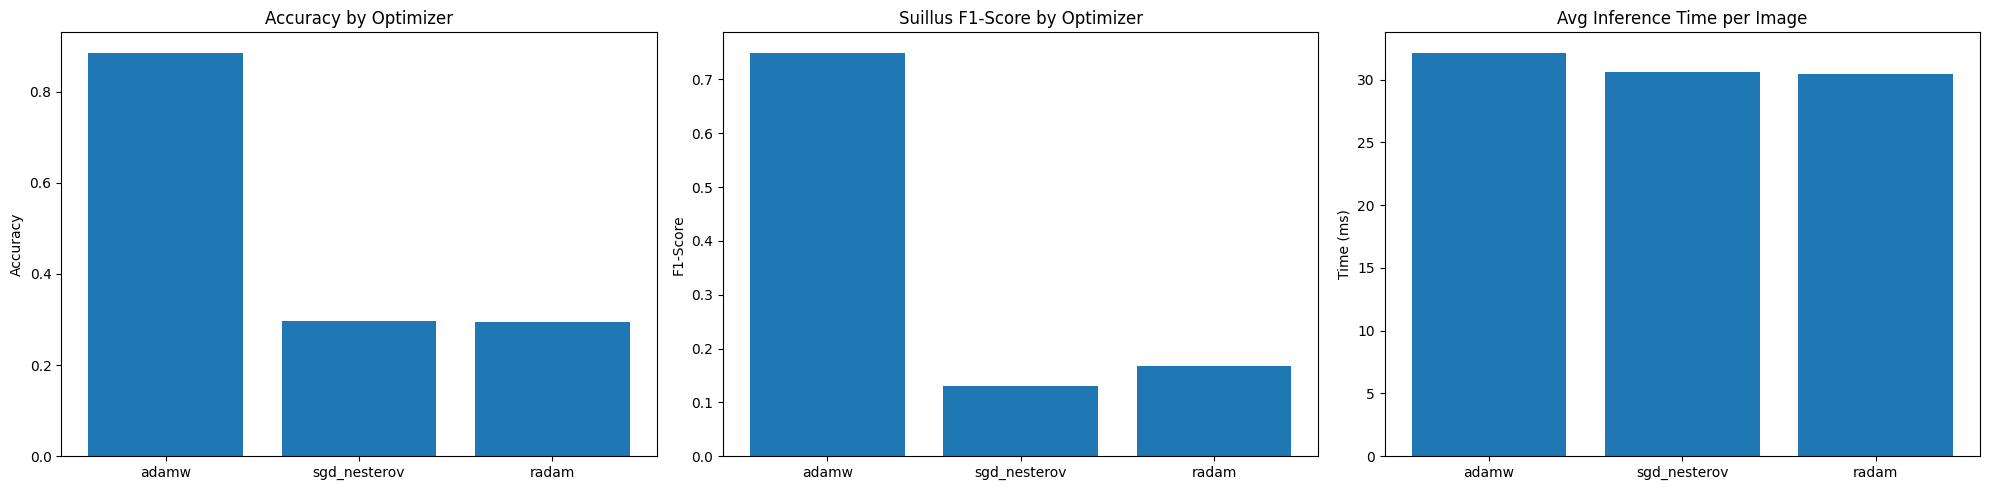

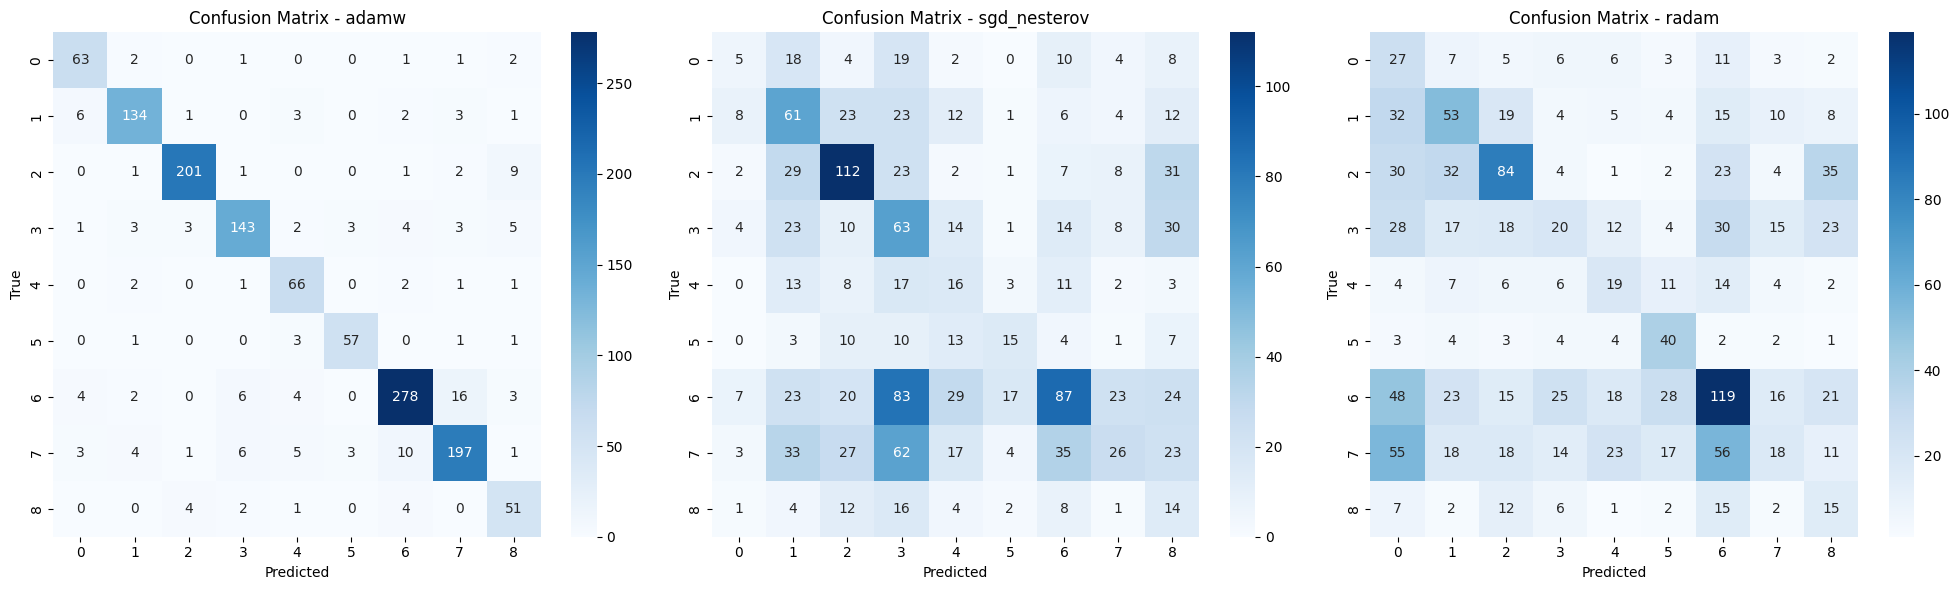


Detailed Results Summary

Results for ADAMW optimizer:
----------------------------------------
Overall Accuracy: 0.8861

Class-wise Performance:
Agaricus        F1-Score: 0.8571 Precision: 0.8182 Recall: 0.9000
Amanita         F1-Score: 0.8963 Precision: 0.8993 Recall: 0.8933
Boletus         F1-Score: 0.9459 Precision: 0.9571 Recall: 0.9349
Cortinarius     F1-Score: 0.8746 Precision: 0.8938 Recall: 0.8563
Entoloma        F1-Score: 0.8408 Precision: 0.7857 Recall: 0.9041
Hygrocybe       F1-Score: 0.9048 Precision: 0.9048 Recall: 0.9048
Lactarius       F1-Score: 0.9041 Precision: 0.9205 Recall: 0.8882
Russula         F1-Score: 0.8678 Precision: 0.8795 Recall: 0.8565
Suillus         F1-Score: 0.7500 Precision: 0.6892 Recall: 0.8226

Results for SGD_NESTEROV optimizer:
----------------------------------------
Overall Accuracy: 0.2971

Class-wise Performance:
Agaricus        F1-Score: 0.1000 Precision: 0.1667 Recall: 0.0714
Amanita         F1-Score: 0.3417 Precision: 0.2947 Recall: 0.4067

In [ ]:
if __name__ == "__main__":
    try:
        pl.seed_everything(42)
        Config.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        logger.info(f"Using device: {Config.DEVICE}")
        logger.info(f"Loading data from: {Config.DATA_PATH}")
        
        data_module = MushroomDataModule(
            Config.DATA_PATH,
            batch_size=Config.BATCH_SIZE,
            train_transforms=train_transforms,
            val_transforms=val_transforms
        )
        data_module.setup()
        
        print("\nDataset Information:")
        print(f"Number of classes: {len(data_module.class_to_idx)}")
        print("\nClass weights:")
        for cls, weight in zip(data_module.class_to_idx.keys(), data_module.class_weights):
            print(f"{cls}: {weight:.4f}")
        
        trainer_kwargs = {
            'max_epochs': Config.EPOCHS,
            'accelerator': 'gpu' if torch.cuda.is_available() else 'cpu',
            'devices': 1,
            'callbacks': [
                EarlyStopping(
                    monitor='val_loss', 
                    patience=Config.EARLY_STOPPING_PATIENCE,
                    mode='min'
                ),
                ModelCheckpoint(
                    monitor='val_loss',
                    dirpath=str(checkpoint_dir),
                    filename='model-{epoch:02d}-{val_loss:.2f}',
                    save_top_k=1,
                    mode='min',
                    verbose=False
                )
            ],
            'enable_progress_bar': True,
            'num_sanity_val_steps': 0,  # Disable sanity check for Windows compatibility
            'deterministic': True  # Ensure reproducibility
        }
        
        results = {}
        optimizers = ['adamw', 'sgd_nesterov', 'radam']
        
        for opt_name in optimizers:
            print(f"\nTraining with {opt_name.upper()} optimizer")
            print("="*50)
            
            opt_checkpoint_dir = checkpoint_dir / opt_name
            opt_checkpoint_dir.mkdir(exist_ok=True)
            
            trainer_kwargs['callbacks'][1].dirpath = str(opt_checkpoint_dir)
            
            try:
                model = EnhancedMushroomClassifier(
                    class_weights=data_module.class_weights,
                    optimizer_name=opt_name
                )
                
                trainer = pl.Trainer(**trainer_kwargs)
                trainer.fit(model, data_module)
                
                results[opt_name] = evaluate_model(model, data_module)
                
                total_inference_time = results[opt_name]['total_inference_time']
                avg_inference_time = results[opt_name]['avg_inference_time_per_image']
                
                print(f"\nIntermediate Results for {opt_name.upper()}:")
                print(f"Accuracy: {results[opt_name]['classification_report']['accuracy']:.4f}")
                print(f"Suillus F1-Score: {results[opt_name]['classification_report']['Suillus']['f1-score']:.4f}")
                print(f"Total Inference Time: {total_inference_time:.4f} seconds")
                print(f"Average Inference Time per Image: {avg_inference_time * 1000:.4f} ms")
                
                with open(opt_checkpoint_dir / 'model_summary.txt', 'w') as f:
                    f.write(f"Model Performance Summary - {opt_name}\n")
                    f.write("="*50 + "\n")
                    f.write(f"Accuracy: {results[opt_name]['classification_report']['accuracy']:.4f}\n")
                    f.write(f"Total Inference Time: {total_inference_time:.4f} seconds\n")
                    f.write(f"Average Inference Time per Image: {avg_inference_time * 1000:.4f} ms\n")
                    f.write("\nClass-wise Performance:\n")
                    for class_name, metrics in results[opt_name]['classification_report'].items():
                        if isinstance(metrics, dict):
                            f.write(f"{class_name:15} "
                                    f"F1-Score: {metrics['f1-score']:.4f} "
                                    f"Precision: {metrics['precision']:.4f} "
                                    f"Recall: {metrics['recall']:.4f}\n")
                
            except Exception as e:
                logger.error(f"Error during training with {opt_name}: {str(e)}")
                continue
        
        if results:
            plot_results(results)
            plot_confusion_matrices(results)
            
            print("\nDetailed Results Summary")
            print("="*50)
            
            for opt_name, result in results.items():
                print(f"\nResults for {opt_name.upper()} optimizer:")
                print("-"*40)
                report = result['classification_report']
                
                print(f"Overall Accuracy: {report['accuracy']:.4f}")
                print("\nClass-wise Performance:")
                for class_name in data_module.class_to_idx.keys():
                    metrics = report[class_name]
                    print(f"{class_name:15} "
                          f"F1-Score: {metrics['f1-score']:.4f} "
                          f"Precision: {metrics['precision']:.4f} "
                          f"Recall: {metrics['recall']:.4f}")
    
    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        raise



  ## 6. Results Analysis



 The intermediate layers proved beneficial, especially when combined with AdamW optimizer. While the improvement in overall accuracy was modest (0.61%), the real value came in:



 - Better class separation

 - More stable training

 - Improved handling of difficult classes

 - Better feature representation



 The architecture shows promise but could potentially benefit from further tuning, especially for the struggling classes like Suillus.



 **Key Findings**:



 1. **Best Performing Optimizer: AdamW**

 - Highest overall accuracy at 88.61%

 - Best Suillus F1-score at 0.75

 - Strong performance across all classes

 - Particularly good at handling:

   - Boletus (F1: 0.9459)

   - Lactarius (F1: 0.9041)

   - Amanita (F1: 0.8963)



 2. **Poor Performance of Alternative Optimizers**

 - SGD with Nesterov momentum:

   - Low accuracy (29.71%)

   - Poor Suillus F1-score (0.1308)

   - Struggled with most classes

 - RAdam:

   - Similarly low accuracy (29.41%)

   - Slightly better Suillus F1-score (0.1667)

   - Best performance on Hygrocybe (F1: 0.4598)



 3. **Class-wise Analysis (AdamW)**

 - Strongest Classifications:

   - Boletus (F1: 0.9459, Precision: 0.9571, Recall: 0.9349)

   - Lactarius (F1: 0.9041, Precision: 0.9205, Recall: 0.8882)

   - Hygrocybe (F1: 0.9048, both Precision and Recall: 0.9048)

 - Areas for Improvement:

   - Suillus (F1: 0.7500) - still the weakest class despite improvements

   - Entoloma (F1: 0.8408) - lower precision (0.7857)



 4. **Improvements Over Previous Model**

 - Overall accuracy increased from 88% to 88.61%

 - Suillus F1-score improved from 0.73 to 0.75

 - Better handling of Lactarius-Russula confusion (both showing F1-scores > 0.86)



 Recommendations:



 1. **Optimizer Selection**

 - Clearly stick with AdamW for this specific task

 - The significant performance gap suggests AdamW handles the complex architecture better



 2. **Further Improvements**

 - Additional focused augmentation for Suillus class

 - Experiment with architecture modifications specifically for Entoloma precision

 - Maybe trying ensemble methods combining AdamW-trained models